<a href="https://colab.research.google.com/github/fernandofsilva/Challenges/blob/master/notebooks/03_modelo_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [7]:
#@title Carregando as bibliotecas base
import pandas as pd
import numpy as np
import tensorflow as tf

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style('whitegrid')

In [10]:
#@title Carregando os dados
data = pd.read_csv(f'/content/drive/My Drive/Mestrado/data/dados_treino_teste.csv.gz', compression='gzip', index_col=0)
data.head()

,codigo,mercado,preco_opcao,preco_exercicio,data_vencimento,T,preco_ativo,volatilidade,taxa_juros,black_scholes,delta_black_scholes,base
2015-01-05,PETRM17,OPÇÕES DE VENDA,8.18,16.91,2015-01-19,0.039683,8.61,0.771953,0.1157,8.22,100,treino
2015-01-05,PETRM28,OPÇÕES DE VENDA,0.36,8.41,2015-01-19,0.039683,8.61,0.771953,0.1157,0.41,40,treino
2015-01-05,PETRM2,OPÇÕES DE VENDA,0.02,4.91,2015-01-19,0.039683,8.61,0.771953,0.1157,0.00,0,teste
2015-01-05,PETRM23,OPÇÕES DE VENDA,0.79,9.21,2015-01-19,0.039683,8.61,0.771953,0.1157,0.87,63,treino
2015-01-05,PETRM25,OPÇÕES DE VENDA,1.13,9.61,2015-01-19,0.039683,8.61,0.771953,0.1157,1.16,73,treino


# Engenharia das variáveis (Feature Engineering)

Essa sessão é composta da transformação dos dados para entrada na rede na rede neural. Portando, as variáveis são transformadas do seu valor original, seja para adequação dentro da rede neural ou para um melhor treinamento da rede, essas transformações são:

- Variavéis númericas: preco_exercicio, preco_ativo, foram normalizadas antes da entrada na rede
- Variavéis númericas: preco_opcao (alvo), volatilidade, taxa_juros e T não sofreram alterações
- Variável categórica mercado sofreu one hot encoding

In [23]:
#@title Pipeline de entrada dos dados
def df_to_dataset(dataframe, base, shuffle=True, batch_size=22):

    # Criar cópia do dataframe
    dataframe = dataframe.copy()

    # Filtrar a base
    dataframe = dataframe[dataframe['base'] == base]

    # Variavel alvo
    labels = dataframe.pop('preco_opcao')

    # Colunas do modelo
    cols = ['mercado', 'preco_exercicio', 'preco_ativo', 'T', 'volatilidade', 'taxa_juros']

    # Criar o td.data
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe[cols]), labels))

    # Embaralhar os dados se necessário
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))

    # Criar o batch de dados
    ds = ds.batch(batch_size)

    return ds

train_ds = df_to_dataset(data, base='treino')
test_ds = df_to_dataset(data, shuffle=False, base='teste')

In [24]:
#@title Mapeamento das colunas
feature_columns = []

# Colunas númericas normalizadas
for column in ['preco_exercicio', 'preco_ativo']:
    
    mean = data.loc[data['base'] == 'treino', column].mean()
    stdev = data.loc[data['base'] == 'treino', column].std()

    feature_columns.append(tf.feature_column.numeric_column(column, normalizer_fn = lambda x: (x - mean) / stdev))

# Colunas númericas sem normalização
for column in ['T', 'volatilidade', 'taxa_juros']:

    feature_columns.append(tf.feature_column.numeric_column(column))

# Colunas categóricas
option = tf.feature_column.categorical_column_with_vocabulary_list('mercado', ['OPÇÕES DE COMPRA', 'OPÇÕES DE VENDA'])
option_one_hot = tf.feature_column.indicator_column(option)
feature_columns.append(option_one_hot)

In [25]:
#@title Camada de transformação (feature layer)
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [26]:
model = tf.keras.Sequential([
  feature_layer,
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(0.001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None)]
)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5
)

Epoch 1/5
Consider rewriting this model with the Functional API.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Consider rewriting this model with the Functional API.
7400/7416 [============================>.] - ETA: 0s - loss: 0.1604 - root_mean_squared_error: 0.4004WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'mercado': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=string>, 'preco_exercicio': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'preco_ati

In [27]:
history

# Modelo

A rede é composta por uma camada de entrada de 128 nós com função de ativação relu, uma camada escondida (intermediária) com 128 nós e uma camada de saida de 1 nó.

Foi definido um callback para EarlyStop (parar o treinamento antes do limite definido de épocas) com valor de 0.075 de validation loss, foi analisado que o valor de 0.075 de perda na validação é o limite de aprendizado, que após esse valor, a rede não melhora e se torna instável.

In [ ]:
#@title Model
class DNN_Model(Model):
  def __init__(self):
    super(DNN_Model, self).__init__()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(128, activation='relu')
    self.d3 = Dense(10)

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    return self.d3(x)

# Create an instance of the model
model = DNN_Model()

In [ ]:
#@title Loss and Optimizer
loss_object = tf.keras.losses.MeanSquaredError(reduction="auto", name="mse")

optimizer = tf.keras.optimizers.Adam(0.001)

In [ ]:
#@title Metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
#@title Gradient
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [ ]:
#@title Test function
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
#@title Training
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

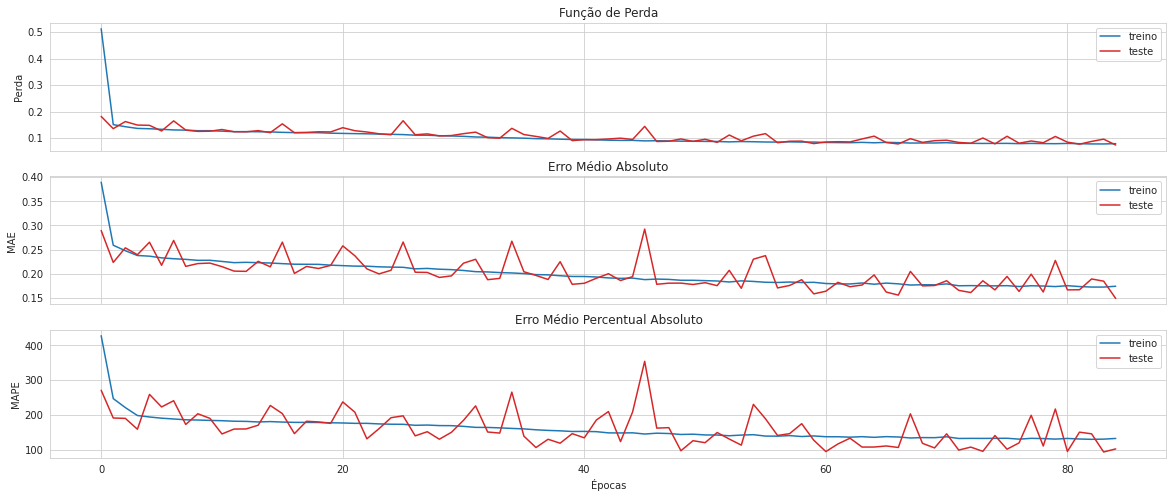

In [ ]:
#@title Plot das Métricas do Modelo
# Split variables
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_mae = history.history['MAE']
test_mae = history.history['val_MAE']
train_mape = history.history['MAPE']
test_mape = history.history['val_MAPE']
epoch = range(len(test_mape))

# Create two subplots
fig, axs = plt.subplots(3, 1, figsize=(20, 8))
axs[0].plot(epoch, train_loss, 'tab:blue', label='treino')
axs[0].plot(epoch, test_loss, 'tab:red', label='teste')
axs[0].set_title('Função de Perda')
axs[0].set(ylabel='Perda')
# axs[0].set_ylim([0, 1])
axs[0].legend()

axs[1].plot(epoch, train_mae, 'tab:blue', label='treino')
axs[1].plot(epoch, test_mae, 'tab:red', label='teste')
axs[1].set_title('Erro Médio Absoluto')
axs[1].set(ylabel='MAE')
# axs[1].set_ylim([0, 2])
axs[1].legend()

axs[2].plot(epoch, train_mape, 'tab:blue', label='treino')
axs[2].plot(epoch, test_mape, 'tab:red', label='teste')
axs[2].set_title('Erro Médio Percentual Absoluto')
axs[2].set(ylabel='MAPE')
# axs[2].set_ylim([0, 2])
axs[2].legend()

for ax in axs.flat:
    ax.set(xlabel='Épocas')

for ax in axs.flat:
    ax.label_outer()

plt.show()

In [ ]:
#@title Salvando o modelo para reutilização
version = '100'
model.save(f"drive/My Drive/Models/model_option_dnn_{version}.h5")

# Gráficos das opções

Para comparação foram escolhidas aleatóriamente 10 opções da base de teste.

In [ ]:
#@title Função de comparação
from sklearn.metrics import mean_squared_error

def predict(model, data, options, expire):

    # Select options
    df = data[(data['option'] == options) & (data['expire'] == expire)]

    # Convert to dataset
    ds = df_to_dataset(df, shuffle=False)

    # Predict values
    pred = model.predict(ds)

    rmse_bs = np.sqrt(mean_squared_error(df['value'],df['bs']))
    rmse_dnn = np.sqrt(mean_squared_error(df['value'], pred))
    if rmse_dnn < rmse_bs:
        result = 'Rede Neural'
    else:
        result = 'Black-Scholes'

    fig, axs = plt.subplots(figsize=(20, 4))
    axs.plot(df.index, pred, 'tab:blue', label='DNN')
    axs.plot(df.index, df['bs'], 'tab:green', label='BS')
    axs.plot(df.index, df['value'], 'tab:red', label=options)
    axs.set_title(f'{options} - Black-Scholes:{rmse_bs:.4f}, DNN:{rmse_dnn:.4f}, Melhor modelo {result}')
    axs.set(ylabel='Valor R$')
    axs.set(xlabel='data')
    axs.legend()

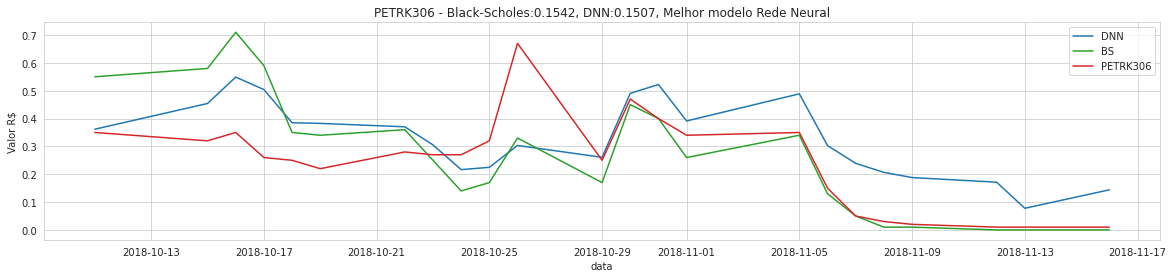

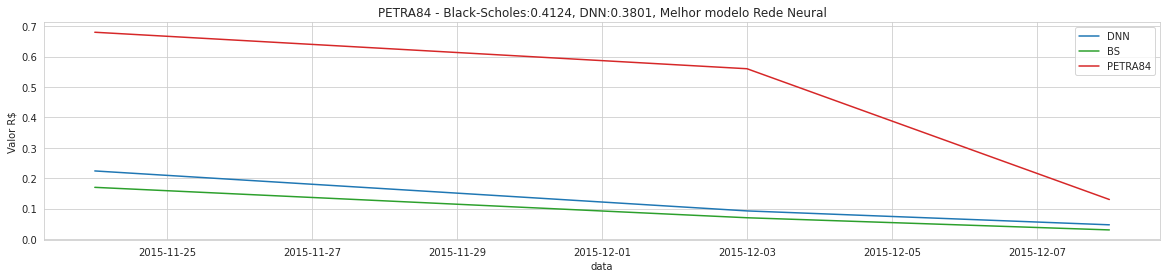

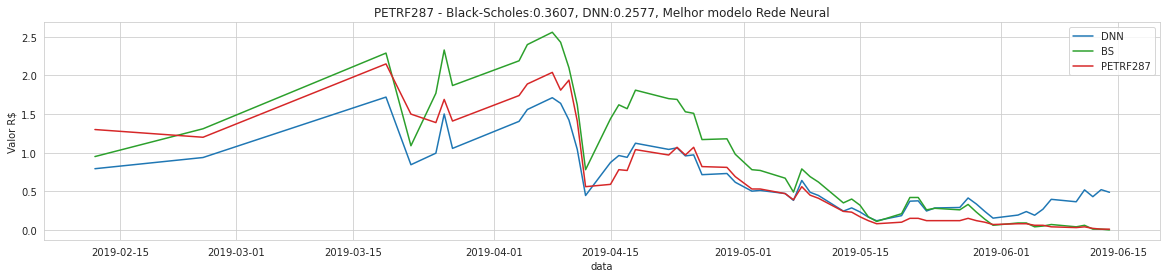

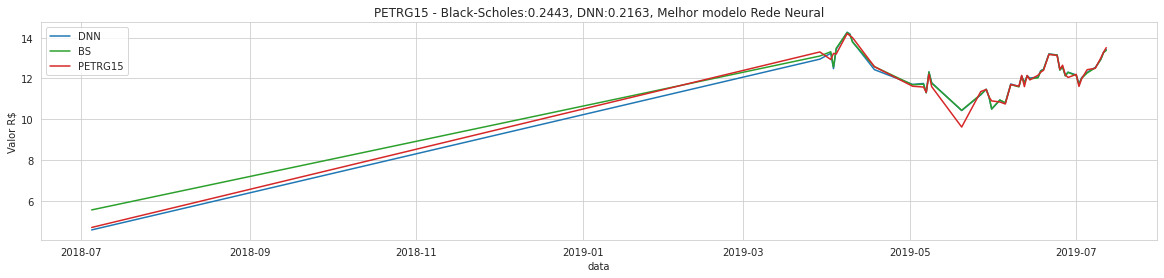

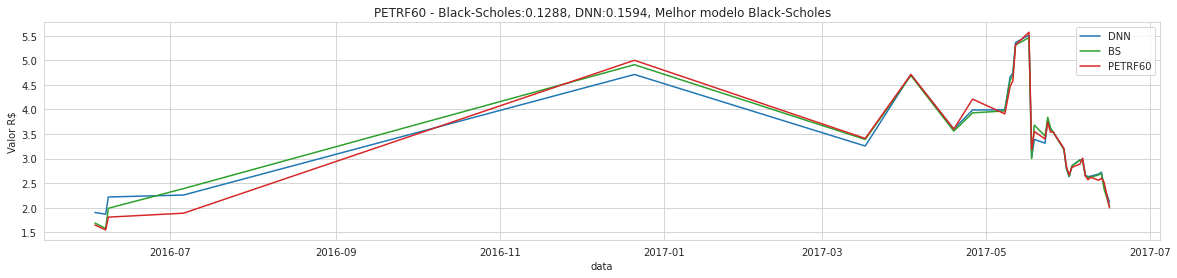

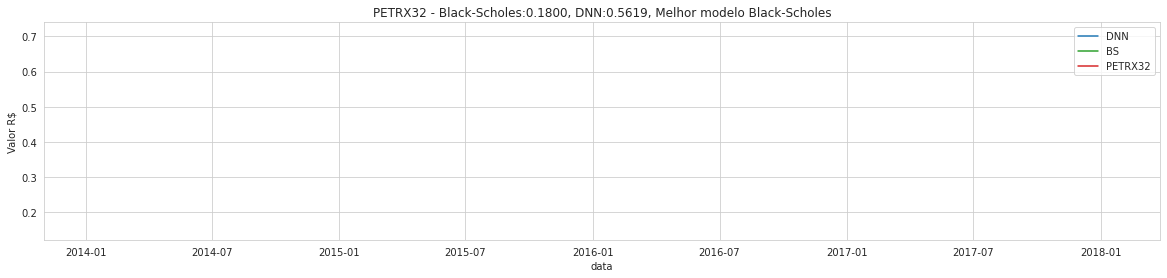

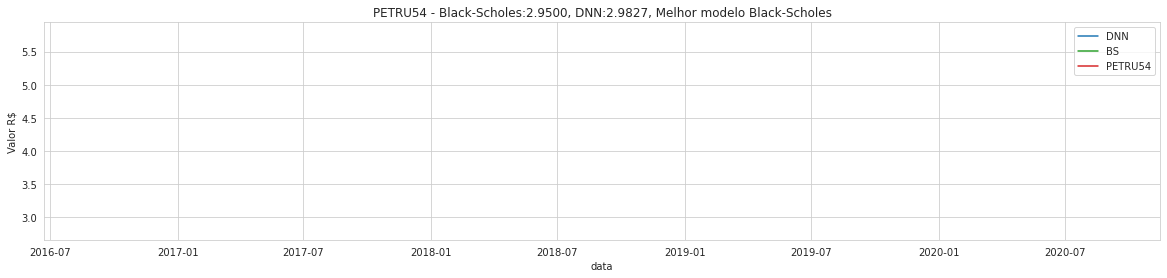

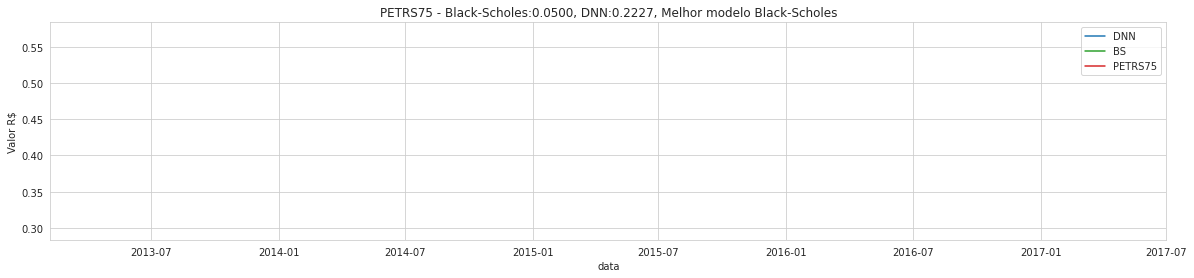

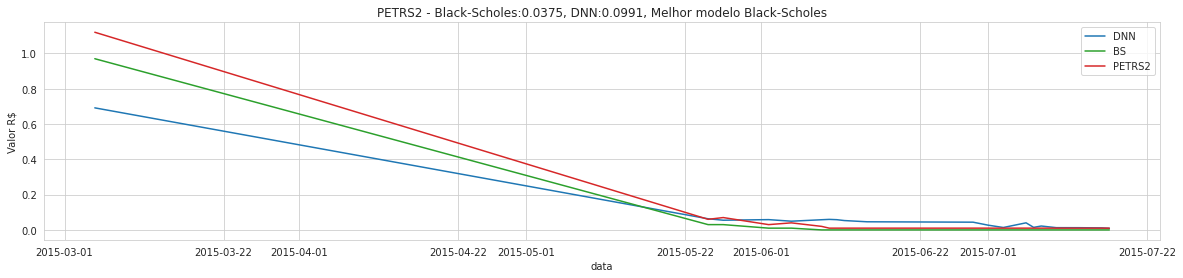

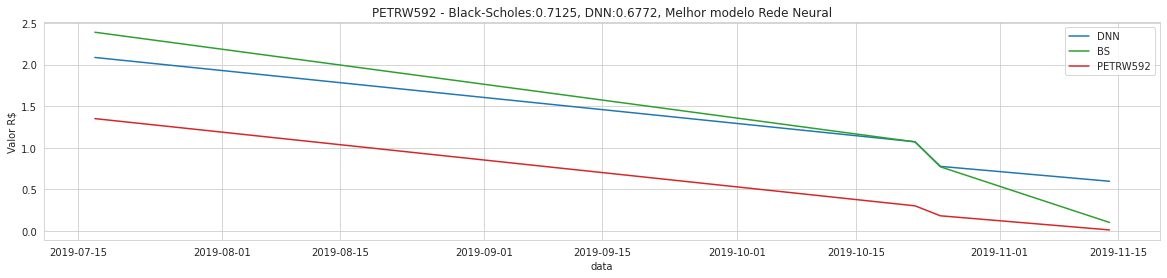

In [ ]:
#@title 
for option_type in ['call', 'put']:
    
    options = test.loc[test['option_type'] == option_type, ['option', 'expire']].drop_duplicates()

    for _ in range(5):

        rand = np.random.randint(options.shape[0])

        predict(
            model,
            data,
            options.iloc[rand, 0],
            options.iloc[rand, 1]
        )

# Referências

Hirsa, A., Karatas, T., & Oskoui, A. (2019). Supervised deep neural networks (DNNS) for pricing/calibration of vanilla exotic options under various different processes. arXiv preprint arXiv:1902.05810.
